Training ARIMA model for RBC...
Training ARIMA model for WBC...
Training ARIMA model for HGB...
Training ARIMA model for PLT...
RBC - Test MSE: 0.4153, Test MAE: 0.5467
WBC - Test MSE: 6.5050, Test MAE: 2.0734
HGB - Test MSE: 3.6486, Test MAE: 1.5769
PLT - Test MSE: 9297.2191, Test MAE: 81.6945


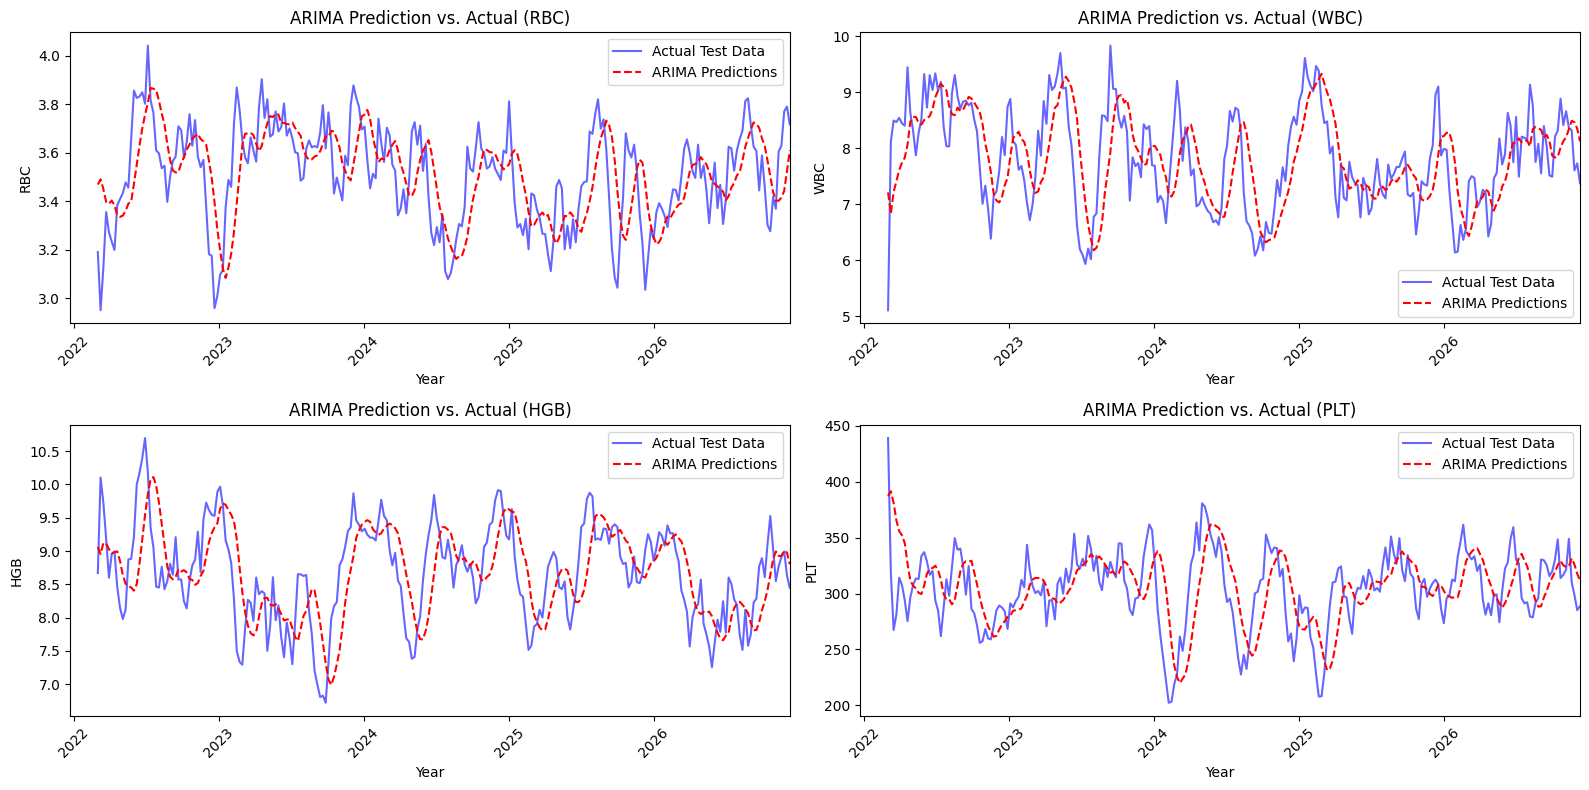

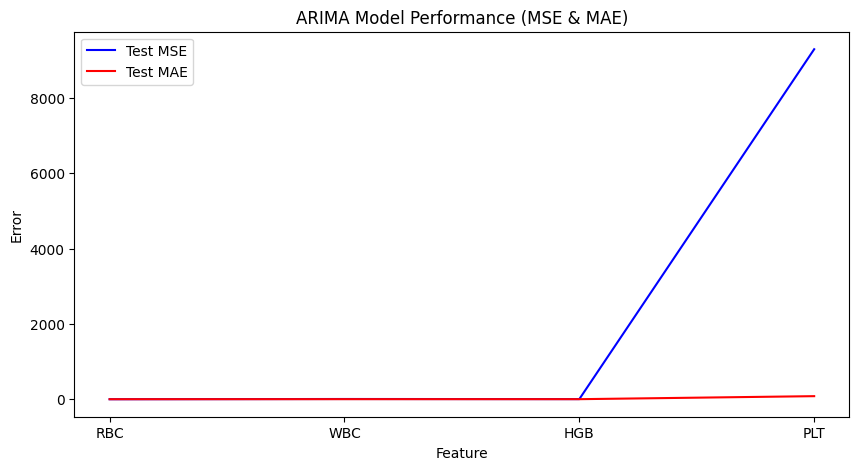

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

# 🔹 Load Dataset
df = pd.read_excel("synthetic_sickle_cbc_updated2.xlsx", parse_dates=["Timestamp"], index_col="Timestamp")

# 🔹 Select multiple features for prediction
target_columns = ["RBC", "WBC", "HGB", "PLT"]
data = df[target_columns]

# 🔹 Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=target_columns, index=df.index)

# 🔹 Split into training & testing sets (80% train, 20% test)
split = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:split], data_scaled[split:]

# 🔹 Function to Train ARIMA Model & Predict
def train_arima(train, test, order=(5, 1, 0)):
    predictions = []
    history = list(train)  # Start with training data

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast()[0]  # Predict next step
        predictions.append(pred)
        history.append(test[t])  # Update history with actual value

    return np.array(predictions)

# 🔹 Train ARIMA for each feature
arima_predictions = {}
for col in target_columns:
    print(f"Training ARIMA model for {col}...")
    arima_predictions[col] = train_arima(train_data[col].values, test_data[col].values)

# 🔹 Convert predictions to DataFrame
arima_predictions_df = pd.DataFrame(arima_predictions, index=test_data.index)

# 🔹 Inverse Transform Predictions & Actual Values
test_actual = scaler.inverse_transform(test_data)
test_predicted = scaler.inverse_transform(arima_predictions_df)

# 🔹 Evaluation Metrics (MSE & MAE)
mse_values = {}
mae_values = {}

for i, col in enumerate(target_columns):
    mse_values[col] = mean_squared_error(test_actual[:, i], test_predicted[:, i])
    mae_values[col] = mean_absolute_error(test_actual[:, i], test_predicted[:, i])
    print(f"{col} - Test MSE: {mse_values[col]:.4f}, Test MAE: {mae_values[col]:.4f}")

# 🔹 Moving Average for Better Visualization (7-week smoothing)
window_size = 7
test_actual_smooth = pd.DataFrame(test_actual, columns=target_columns).rolling(window=window_size, min_periods=1).mean().values
test_predicted_smooth = pd.DataFrame(test_predicted, columns=target_columns).rolling(window=window_size, min_periods=1).mean().values

# 🔹 Visualization: Actual vs. Predicted (Last 5 Years)
recent_years_index = df.index[-(5 * 52):]

plt.figure(figsize=(16, 8))
for i, col in enumerate(target_columns):
    plt.subplot(2, 2, i+1)
    
    # Actual Data
    plt.plot(df.index[split:], test_actual_smooth[:, i], label="Actual Test Data", color="blue", alpha=0.6)
    # Predicted Data
    plt.plot(df.index[split:], test_predicted_smooth[:, i], label="ARIMA Predictions", color="red", linestyle="dashed")

    plt.xlabel("Year")
    plt.ylabel(col)
    plt.title(f"ARIMA Prediction vs. Actual ({col})")
    plt.legend()

    # Set X-axis to yearly ticks
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # 🔹 Focus on Last 5 Years
    plt.xlim([recent_years_index.min(), recent_years_index.max()])

plt.tight_layout()
plt.show()

# 🔹 Loss Visualization: Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(list(mse_values.values()), label="Test MSE", color="blue")
plt.plot(list(mae_values.values()), label="Test MAE", color="red")
plt.xlabel("Feature")
plt.ylabel("Error")
plt.title("ARIMA Model Performance (MSE & MAE)")
plt.xticks(range(len(target_columns)), target_columns)
plt.legend()
plt.show()
